In [1]:
# Libraries 
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import glob
import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary




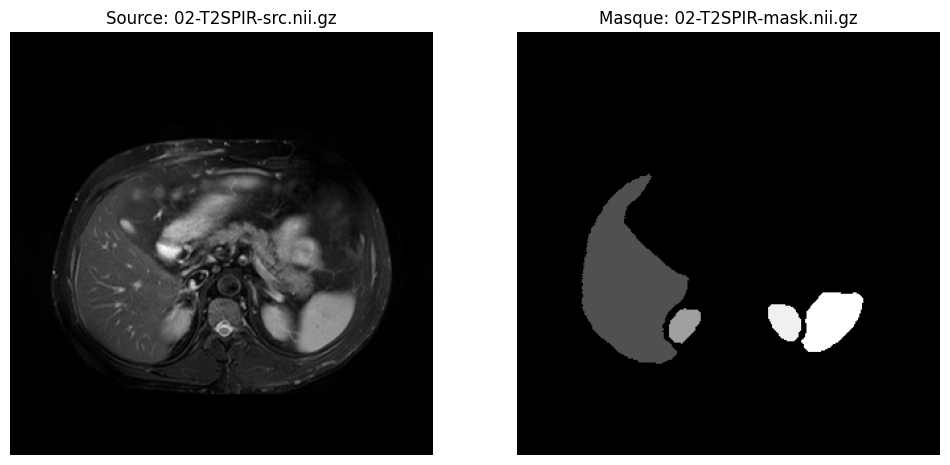

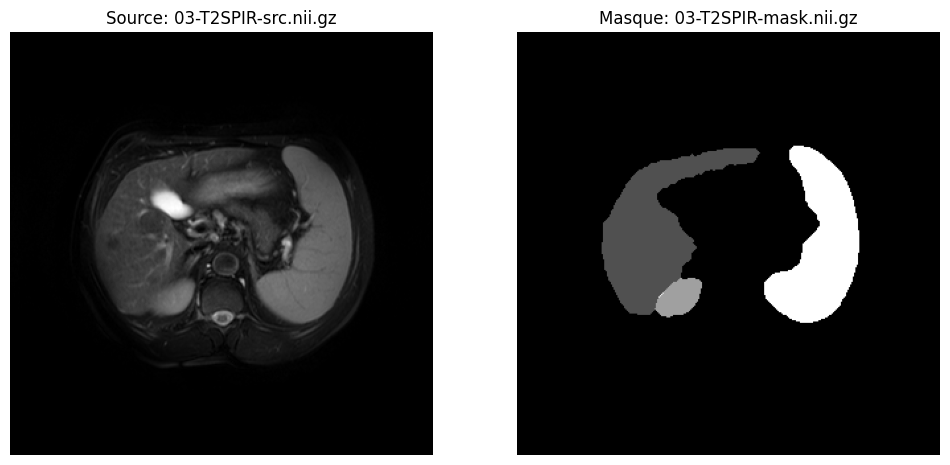

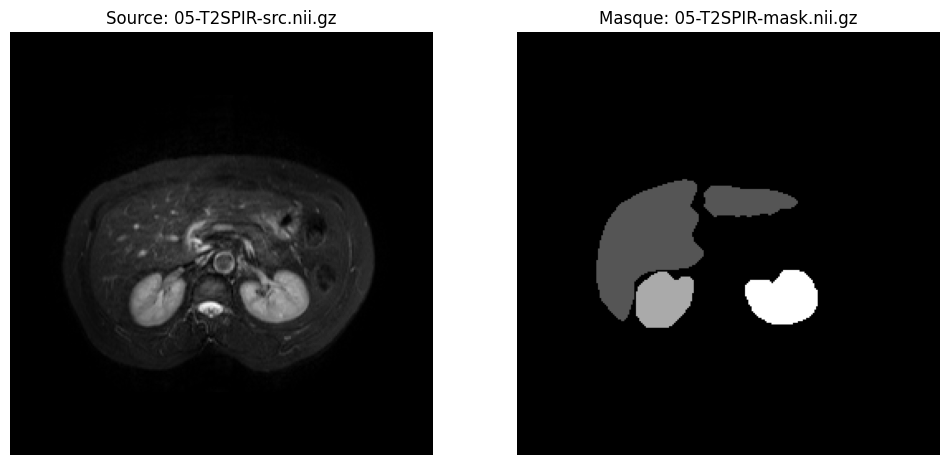

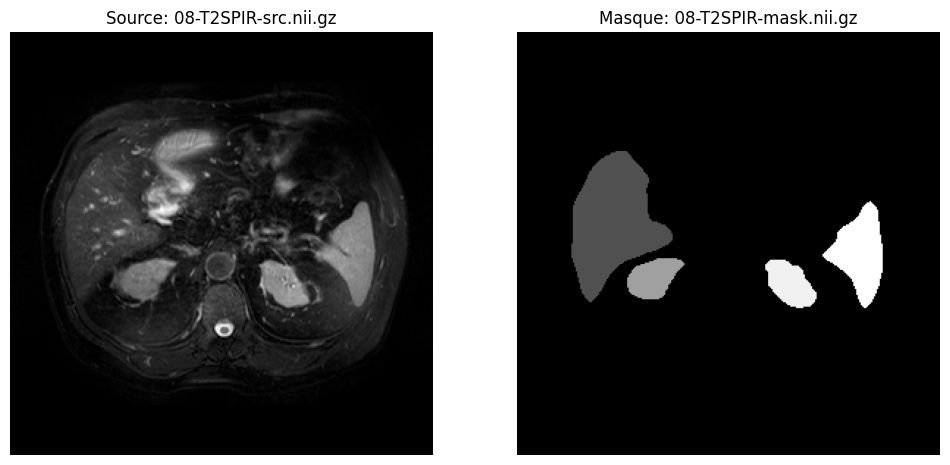

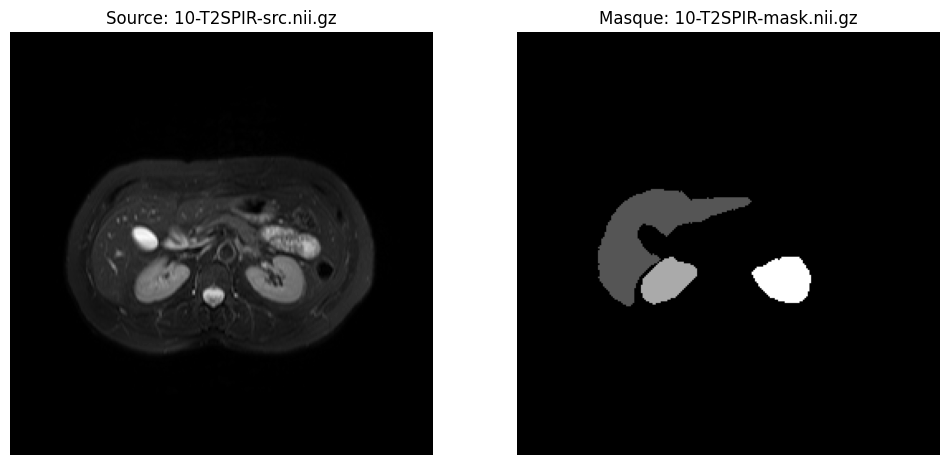

In [2]:
#Affichage des données
# Spécifiez le chemin du dossier contenant les fichiers .nii.gz
folder_path = 'CHAOS-MRT2'

# Lister tous les fichiers dans le dossier
files = os.listdir(folder_path)

# Séparer les fichiers source et masque à partir de "02"
src_files = sorted([f for f in files if f.endswith('-src.nii.gz') and '02' <= f[:2] <= '10'])
mask_files = sorted([f for f in files if f.endswith('-mask.nii.gz') and '02' <= f[:2] <= '10'])

# Vérifier que le nombre de fichiers source et masque correspond
assert len(src_files) == len(mask_files), "Le nombre de fichiers source et masque ne correspond pas!"

# Afficher les 10 premiers fichiers source et masque
for i in range(min(10, len(src_files))):
    src_file = src_files[i]
    mask_file = mask_files[i]
    
    # Obtenir les chemins complets des fichiers
    src_path = os.path.join(folder_path, src_file)
    mask_path = os.path.join(folder_path, mask_file)
    
    # Charger les images source et masque
    src_img = nib.load(src_path).get_fdata()
    mask_img = nib.load(mask_path).get_fdata()
    
    # Extraire une coupe 2D au milieu de l'axe z
    slice_z_src = src_img[:, :, src_img.shape[2] // 2]
    slice_z_mask = mask_img[:, :, mask_img.shape[2] // 2]
    
    # Créer une figure pour afficher les deux images côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Afficher l'image source
    axes[0].imshow(slice_z_src.T, cmap='gray', origin='lower')
    axes[0].set_title(f'Source: {src_file}')
    axes[0].axis('off')
    
    # Afficher l'image masque
    axes[1].imshow(slice_z_mask.T, cmap='gray', origin='lower')
    axes[1].set_title(f'Masque: {mask_file}')
    axes[1].axis('off')
    
    # Afficher la figure
    plt.show()


In [3]:
# Test pour verifier si les images sont de quel format (float64 et 5 valeurs pour les masques)

folder_path_normalized='CHAOS-MRT2-NORMALIZED'
filesBis = os.listdir(folder_path_normalized)

nii_file = filesBis[0]  # ou .nii si vous avez des fichiers non compressés
src_path = os.path.join(folder_path_normalized, nii_file)
nii_img = nib.load(src_path)

# Extraire les données sous forme de tableau NumPy
mask_array = nii_img.get_fdata()

# Vérifier le type des données
print(mask_array.dtype)

# Vérifier les valeurs uniques dans le masque
print(np.unique(mask_array))

float64
[0. 1. 2. 3. 4.]


In [4]:
# Code pour convertir les fichiers en bon format.
''''
# Dossiers d'entrée et de sortie
input_folder = 'CHAOS-MRT2'  # Chemin vers votre dossier avec les fichiers NIfTI
output_folder = 'CHAOS-MRT2-NORMALIZED'     # Chemin vers le dossier de sortie

# Créer le dossier de sortie s'il n'existe pas
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Fonction pour normaliser les fichiers sources
def normalize_image(image_array):
    return (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))

# Fonction pour convertir les masques en classes entières
def convert_mask(mask_array):
    mask_array_int = np.zeros_like(mask_array, dtype=np.uint8)
    mask_array_int[mask_array == 0] = 0  # Arrière-plan
    mask_array_int[mask_array == 80] = 1  # Classe 1
    mask_array_int[mask_array == 160] = 2  # Classe 2
    mask_array_int[mask_array == 240] = 3  # Classe 3
    mask_array_int[mask_array == 255] = 4  # Classe 4 (à vérifier)
    return mask_array_int

# Parcourir tous les fichiers du dossier
for filename in os.listdir(input_folder):
    if filename.endswith('-src.nii.gz'):  # Fichier source (image)
        # Charger le fichier source
        src_path = os.path.join(input_folder, filename)
        src_img = nib.load(src_path)
        src_array = src_img.get_fdata()

        # Normaliser l'image A voir s'il faut le garder.
        src_array_norm = normalize_image(src_array).astype(np.float32)

        # Sauvegarder l'image normalisée
        output_path = os.path.join(output_folder, filename)
        new_src_img = nib.Nifti1Image(src_array_norm, affine=src_img.affine)
        nib.save(new_src_img, output_path)
        print(f"Image source normalisée sauvegardée : {output_path}")

    elif filename.endswith('-mask.nii.gz'):  # Fichier masque
        # Charger le fichier masque
        mask_path = os.path.join(input_folder, filename)
        mask_img = nib.load(mask_path)
        mask_array = mask_img.get_fdata()

        # Convertir les masques en classes entières
        mask_array_int = convert_mask(mask_array)

        # Sauvegarder le masque converti
        output_path = os.path.join(output_folder, filename)
        new_mask_img = nib.Nifti1Image(mask_array_int, affine=mask_img.affine)
        nib.save(new_mask_img, output_path)
        print(f"Masque converti sauvegardé : {output_path}")
'''

'\'\n# Dossiers d\'entrée et de sortie\ninput_folder = \'CHAOS-MRT2\'  # Chemin vers votre dossier avec les fichiers NIfTI\noutput_folder = \'CHAOS-MRT2-NORMALIZED\'     # Chemin vers le dossier de sortie\n\n# Créer le dossier de sortie s\'il n\'existe pas\nif not os.path.exists(output_folder):\n    os.makedirs(output_folder)\n\n# Fonction pour normaliser les fichiers sources\ndef normalize_image(image_array):\n    return (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))\n\n# Fonction pour convertir les masques en classes entières\ndef convert_mask(mask_array):\n    mask_array_int = np.zeros_like(mask_array, dtype=np.uint8)\n    mask_array_int[mask_array == 0] = 0  # Arrière-plan\n    mask_array_int[mask_array == 80] = 1  # Classe 1\n    mask_array_int[mask_array == 160] = 2  # Classe 2\n    mask_array_int[mask_array == 240] = 3  # Classe 3\n    mask_array_int[mask_array == 255] = 4  # Classe 4 (à vérifier)\n    return mask_array_int\n\n# Parcourir tous 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cpu


In [5]:
# Chemin vers votre dossier contenant les fichiers CHAOS
chaos_dir = 'CHAOS-MRT2-NORMALIZED'

# Récupérer tous les fichiers .nii.gz
all_src_files = sorted(glob.glob(os.path.join(chaos_dir, '*-src.nii.gz')))
all_mask_files = sorted(glob.glob(os.path.join(chaos_dir, '*-mask.nii.gz')))

# Vérification de la correspondance des fichiers src et mask
assert len(all_src_files) == len(all_mask_files), "Le nombre de fichiers source et masque ne correspond pas!"

# Fonction pour obtenir la taille d'un fichier .nii.gz
def get_nii_shape(file_path):
    nii = nib.load(file_path)
    return nii.shape

# Afficher les tailles des fichiers sources et masques
print("Tailles des fichiers sources (src) :")
for src_file in all_src_files:
    shape = get_nii_shape(src_file)
    print(f"{os.path.basename(src_file)} : {shape}")

print("\nTailles des fichiers masques (mask) :")
for mask_file in all_mask_files:
    shape = get_nii_shape(mask_file)
    print(f"{os.path.basename(mask_file)} : {shape}")

# Fonction pour charger les fichiers .nii.gz en tensors
def load_nii_to_tensor(file_path):
    nii = nib.load(file_path)
    img_data = nii.get_fdata()
    tensor_data = torch.tensor(img_data, dtype=torch.float32)
    return tensor_data

# Fonction pour redimensionner les images 3D à une taille cible (ex: [256, 256, 32])
def resize_tensor(tensor, target_shape):
    # torch.nn.functional.interpolate travaille sur des tensors de 4 dimensions (batch, channels, depth, height, width)
    tensor = tensor.unsqueeze(0).unsqueeze(0)  # Ajouter des dimensions batch et channel
    resized_tensor = F.interpolate(tensor, size=target_shape, mode='trilinear', align_corners=False)
    return resized_tensor.squeeze()  # Supprimer les dimensions supplémentaires

# Taille cible (à adapter selon vos besoins)
target_shape = (256, 256, 32)

# Charger et redimensionner les données
src_data = [resize_tensor(load_nii_to_tensor(src), target_shape) for src in all_src_files]
mask_data = [resize_tensor(load_nii_to_tensor(mask), target_shape) for mask in all_mask_files]

# Séparer les données en ensembles d'entraînement et de test (80% train, 20% test)
train_src, test_src, train_mask, test_mask = train_test_split(src_data, mask_data, test_size=0.2, random_state=42)

# Convertir en tensors PyTorch
x_train = torch.stack(train_src)  # Ensemble d'entraînement (inputs)
y_train = torch.stack(train_mask)  # Ensemble d'entraînement (labels)

x_test = torch.stack(test_src)  # Ensemble de test (inputs)
y_test = torch.stack(test_mask)  # Ensemble de test (labels)

# Afficher les formes finales des tensors
print(f'Train X shape: {x_train.shape}, Train Y shape: {y_train.shape}')
print(f'Test X shape: {x_train.shape}, Test Y shape: {y_train.shape}')


Tailles des fichiers sources (src) :
02-T2SPIR-src.nii.gz : (320, 320, 26)
03-T2SPIR-src.nii.gz : (320, 320, 30)
05-T2SPIR-src.nii.gz : (256, 256, 30)
08-T2SPIR-src.nii.gz : (288, 288, 32)
10-T2SPIR-src.nii.gz : (256, 256, 36)
13-T2SPIR-src.nii.gz : (320, 320, 30)
15-T2SPIR-src.nii.gz : (256, 256, 26)
19-T2SPIR-src.nii.gz : (320, 320, 30)
20-T2SPIR-src.nii.gz : (320, 320, 26)
21-T2SPIR-src.nii.gz : (256, 256, 31)
22-T2SPIR-src.nii.gz : (256, 256, 33)
31-T2SPIR-src.nii.gz : (256, 256, 29)
32-T2SPIR-src.nii.gz : (256, 256, 39)
33-T2SPIR-src.nii.gz : (256, 256, 29)
34-T2SPIR-src.nii.gz : (256, 256, 30)
36-T2SPIR-src.nii.gz : (256, 256, 38)
37-T2SPIR-src.nii.gz : (256, 256, 32)
38-T2SPIR-src.nii.gz : (320, 320, 34)
39-T2SPIR-src.nii.gz : (256, 256, 26)

Tailles des fichiers masques (mask) :
02-T2SPIR-mask.nii.gz : (320, 320, 26)
03-T2SPIR-mask.nii.gz : (320, 320, 30)
05-T2SPIR-mask.nii.gz : (256, 256, 30)
08-T2SPIR-mask.nii.gz : (288, 288, 32)
10-T2SPIR-mask.nii.gz : (256, 256, 36)
13-T2SP

In [6]:
# Architecture U-net Classique
#On peut ajouter du dropout a la fin pour essayer
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=5):
        super(UNet3D, self).__init__()
        
        # Contracting path
        self.enc1 = self.contract_block(in_channels, 64)
        self.enc2 = self.contract_block(64, 128)
        self.enc3 = self.contract_block(128, 256)
        self.enc4 = self.contract_block(256, 512)

        # Bottleneck
        self.bottleneck = self.contract_block(512, 1024)
        # Expanding path
        self.dec4 = self.expand_block(1536, 512)
        self.dec3 = self.expand_block(768, 256)
        self.dec2 = self.expand_block(384, 128)
        self.dec1 = self.expand_block(192, 64)

        # Output layer
        self.final_conv = nn.Conv3d(64, out_channels, kernel_size=1)

    def contract_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )

    def expand_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def up_concat(self, x1, x2):
        """
        Fonction pour le chemin de décodage (concaténation avec skip connections)
        """
        # Redimensionner x1 pour qu'il corresponde à la taille de x2
        x1 = F.interpolate(x1, size=x2.size()[2:], mode='trilinear', align_corners=True)
        return torch.cat([x1, x2], dim=1)

    
    def forward(self, x):
        # Encode
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc4)

        # Decode 

        dec4 = self.up_concat(bottleneck,enc4)
        dec4 = self.dec4(dec4)
        
        dec3 = self.up_concat(dec4,enc3)
        dec3 = self.dec3(dec3)
        
        dec2 = self.up_concat(dec3,enc2)
        dec2 = self.dec2(dec2)

        dec1 = self.up_concat(dec2,enc1)
        dec1 = self.dec1(dec1)
        return self.final_conv(dec1)

model = UNet3D()

# Summary of the model
#summary(model, input_size=(1,128, 128,128)) # (channels, depth, height, width)


In [ ]:
# Architecture U-net Avec Augmentation
#On peut ajouter du dropout a la fin pour essayer
"""class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out
        
        
        
"""
class UNetAug3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=5,n_coefficients=3):
        super(UNet3D, self).__init__()
        
        # Contracting path
        self.enc1 = self.contract_block(in_channels, 64)
        self.enc2 = self.contract_block(64, 128)
        self.enc3 = self.contract_block(128, 256)
        self.enc4 = self.contract_block(256, 512)

        # Bottleneck
        self.bottleneck = self.contract_block(512, 1024)
        # Expanding path
        self.dec4 = self.expand_block(1536, 512)
        self.dec3 = self.expand_block(768, 256)
        self.dec2 = self.expand_block(384, 128)
        self.dec1 = self.expand_block(192, 64)

        # Output layer
        self.final_conv = nn.Conv3d(64, out_channels, kernel_size=1)

    def contract_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )

    def expand_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def up_concat(self, x1, x2):
        """
        Fonction pour le chemin de décodage (concaténation avec skip connections)
        """
        # Redimensionner x1 pour qu'il corresponde à la taille de x2
        x1 = F.interpolate(x1, size=x2.size()[2:], mode='trilinear', align_corners=True)
        return torch.cat([x1, x2], dim=1)

    
    def forward(self, x):
        # Encode
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc4)

        # Decode 

        dec4 = self.up_concat(bottleneck,enc4)
        dec4 = self.dec4(dec4)
        
        dec3 = self.up_concat(dec4,enc3)
        dec3 = self.dec3(dec3)
        
        dec2 = self.up_concat(dec3,enc2)
        dec2 = self.dec2(dec2)

        dec1 = self.up_concat(dec2,enc1)
        dec1 = self.dec1(dec1)
        return self.final_conv(dec1)

model = UNet3D()

# Summary of the model
#summary(model, input_size=(1,128, 128,128)) # (channels, depth, height, width)

In [7]:

# Exemple de pondération des classes si la classe 0 est dominante
class_weights = torch.tensor([0.1, 10.0, 15.0, 15.0, 10.0])  # Ajuste les valeurs selon la distribution des classes réelles

# Appliquer la pondération dans la perte
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [8]:
n_epochs = 20 # number of epochs to train the model

def training(model, criterion, optimizer):

  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
  valid_loss_min = np.inf  # set initial "min" to infinity
  i=0
  for epoch in range(n_epochs):
      train_loss, valid_loss = 0, 0 # monitor losses

      # train the model
      model.train() # prep model for training
     
      for data, label in zip(x_train, y_train):
          #Adding the batch and the number of channels
          data = data.unsqueeze(0).unsqueeze(0)  # Shape: [batch_size, 1, depth, height, width]
          label = label.unsqueeze(0).to(device) #sensé mettre de la forme : [batch_size, depth, height, width
          label = label.long().to(device)
          
          optimizer.zero_grad() # clear the gradients of all optimized variables
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model

          loss = criterion(output, label) # calculate the loss
          loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
          optimizer.step() # perform a single optimization step (parameter update)
          train_loss += loss.item() * data.size(0) # update running training loss
          print(train_loss)
          
          #partie pour voir l'évolution
          if i%15==0 :
            softmax_output = F.softmax(output, dim=1)
            predicted_mask = torch.argmax(softmax_output, dim=1).cpu().squeeze().numpy()
              # Convertir en int32 pour éviter les problèmes de compatibilité avec NIfTI
            predicted_mask = predicted_mask.astype(np.int32)
              # Créer un fichier NIfTI pour le masque prédit
            predicted_nii = nib.Nifti1Image(predicted_mask, np.eye(4))  # Créer une matrice d'identité pour l'affine
            nib.save(predicted_nii, "predicted_mask_train0test"+str(i/15)+".nii.gz")
          i+=1

      # validate the model
      model.eval()
      for data, label in zip(x_test,y_test):
        #Adding the batch and the number of channels
        data = data.unsqueeze(0).unsqueeze(0)  # Shape: [batch_size, 1, depth, height, width]
        label = label.unsqueeze(0).to(device) #sensé mettre de la forme : [batch_size, depth, height, width
        label = label.long().to(device)
        
        with torch.no_grad():
            output = model(data)
        loss = criterion(output,label) #Si j'ai 3 channels, il faut modifier la taille de label à voir !
        valid_loss += loss.item() * data.size(0)

      # calculate average loss over an epoch
      train_loss /= len(x_train)
      valid_loss /= len(x_test)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss

  return train_losses, valid_losses

In [9]:
train_losses, valid_losses = training(model, criterion, optimizer)

1.6292697191238403
3.2614352703094482
4.888987898826599
6.518894553184509
8.144478797912598
9.770268440246582
11.393205642700195
13.014271259307861
14.631114959716797
16.247928500175476
17.862345457077026
19.473005890846252
21.079579830169678
22.678925395011902
24.27159357070923
epoch: 1 	training Loss: 1.618106 	validation Loss: 1.572911
validation loss decreased (inf --> 1.572911).  Saving model ...
1.575343132019043
3.081865668296814
4.467597603797913
7.711342453956604
9.186126708984375
10.616701483726501
12.131996631622314
13.672504782676697
15.234992265701294
16.80177080631256
18.362842798233032
19.932944655418396
21.514482855796814
23.09081256389618
24.6732394695282
epoch: 2 	training Loss: 1.644883 	validation Loss: 1.581873
1.5842325687408447
3.1618430614471436
4.7448365688323975
6.320694923400879
7.902869462966919
9.47690486907959
11.056511759757996
12.634324312210083
14.21673059463501
15.794480085372925
17.36402177810669
18.935535550117493
20.514615893363953
22.08400583267212

In [14]:
print(train_losses)
print(valid_losses)

[1.618106238047282, 1.6448826313018798, 1.5772061427434285, 1.4935248295466106, 1.2688742319742838, 1.1974346160888671, 1.162044930458069, 1.1170633912086487, 1.0560863852500915, 0.9687652309735616, 0.880884313583374, 0.8458095550537109, 0.7465836524963378, 0.6368123133977254, 0.6196435173352559, 0.5427512447039287, 0.5583034932613373, 0.6019951204458872, 0.5547107179959615, 0.48700920343399046]
[1.5729106664657593, 1.5818729102611542, 1.5709196627140045, 1.3552048206329346, 1.224452942609787, 1.1808674931526184, 1.1261485815048218, 1.0459165424108505, 0.9727327078580856, 0.9111852943897247, 0.8950274586677551, 0.8360584080219269, 0.7105303555727005, 0.741697296500206, 0.6558889001607895, 0.6077425479888916, 0.5828130841255188, 0.5996378138661385, 0.5091105252504349, 0.5049892961978912]


In [10]:
#FAIRE print les noms des fichiers pour plus de clarté 
def save_predicted_mask(model, input_tensor, output_path):
    """
    Sauvegarde le masque prédit par le modèle sous forme de fichier .nii.gz
    
    :param model: le modèle UNet3D entraîné
    :param input_tensor: tensor d'entrée de forme [1, 1, depth, height, width]
    :param output_path: chemin de sauvegarde du fichier de masque prédictif
    """
    model.eval()  # Mettre le modèle en mode évaluation
    with torch.no_grad():
        # Prédire avec le modèle
        output = model(input_tensor.unsqueeze(0).unsqueeze(0))  # Ajouter batch dim
        # Sortie du modèle [batch_size, n_classes, depth, height, width]
        # Prendre l'argmax pour obtenir la classe la plus probable
        print(f"Valeurs min/max de l'output avant argmax: {output.min()}/{output.max()}")
        softmax_output = F.softmax(output, dim=1)
        print("Softmax Output:", softmax_output[0].cpu().detach().numpy())
        predicted_mask = torch.argmax(softmax_output, dim=1).cpu().squeeze().numpy()

       
        # Convertir en int32 pour éviter les problèmes de compatibilité avec NIfTI
        predicted_mask = predicted_mask.astype(np.int32)
        # Créer un fichier NIfTI pour le masque prédit
        predicted_nii = nib.Nifti1Image(predicted_mask, np.eye(4))  # Créer une matrice d'identité pour l'affine
        nib.save(predicted_nii, output_path)
        print(f"Fichier de masque prédit sauvegardé à {output_path}")
        # Vérifier la distribution des classes dans le masque prédit
        unique_classes, class_counts = np.unique(predicted_mask, return_counts=True)
        print(f"Classes prédites: {unique_classes}")
        print(f"Nombre de pixels par classe: {class_counts}")


# Exemple d'utilisation
# input_tensor est une image unique à prédire
input_tensor = x_train[0]  # Par exemple, on prend la première image du train
output_path = "predicted_mask_train0test.nii.gz"
save_predicted_mask(model, input_tensor, output_path)

Valeurs min/max de l'output avant argmax: -3.501260280609131/4.1183013916015625
Softmax Output: [[[[0.21497424 0.21448733 0.21443044 ... 0.2143394  0.21460631
    0.21587165]
   [0.21407737 0.21297249 0.21263821 ... 0.21262333 0.21304442
    0.21512036]
   [0.21408668 0.21318343 0.212686   ... 0.21262553 0.21317902
    0.21513015]
   ...
   [0.21397811 0.21294366 0.21261927 ... 0.21246862 0.21304129
    0.21503773]
   [0.21418695 0.21335293 0.21285826 ... 0.21278751 0.2132323
    0.21514587]
   [0.2152906  0.21471694 0.21432543 ... 0.21434925 0.21459419
    0.21571672]]

  [[0.21462741 0.21343985 0.21323505 ... 0.21300857 0.2134813
    0.2149095 ]
   [0.2133988  0.2112458  0.21038793 ... 0.21048532 0.21099754
    0.2138448 ]
   [0.21346678 0.21063735 0.2100572  ... 0.20960182 0.21066192
    0.21328683]
   ...
   [0.2130874  0.21063979 0.20966928 ... 0.20968503 0.21031843
    0.21351115]
   [0.21354657 0.21090725 0.21031709 ... 0.20991272 0.21084495
    0.21339925]
   [0.21424992 0.2128

In [ ]:
train_losses, valid_losses = training(model, criterion, optimizer)

1.6505308151245117
3.296612858772278
4.9385188817977905
6.576702117919922
8.210681200027466
9.839797139167786
11.463156461715698
13.081267237663269
14.691658973693848
16.292243599891663
17.879423141479492
19.44804275035858
20.98270094394684
22.44232451915741
23.54625117778778
epoch: 1 	training Loss: 1.569750 	validation Loss: 0.542456
validation loss decreased (inf --> 0.542456).  Saving model ...
0.6097452044487
1.4905081987380981
2.0838623642921448
2.7856889963150024
3.3192131519317627
3.705647647380829
4.512390196323395
4.90331843495369
5.333720862865448
5.750721573829651
6.237009257078171
6.654869914054871
7.020601838827133
7.366955637931824
7.9541813135147095
epoch: 2 	training Loss: 0.530279 	validation Loss: 0.376277
validation loss decreased (0.542456 --> 0.376277).  Saving model ...
0.4158612787723541
0.8349897265434265
1.2745541036128998
1.6530195772647858
1.9510613679885864
2.208206534385681
2.557832956314087
2.798419937491417
3.1398893743753433
3.3793974965810776
3.7346432

In [12]:
#Sauvegarde des poids du modèle : 
# Chemin où tu veux sauvegarder les poids (par exemple, dans un fichier .pth)
checkpoint_path = 'model_weights.pth'

# Sauvegarder les poids du modèle
torch.save(model.state_dict(), checkpoint_path)
print(f"Modèle sauvegardé dans {checkpoint_path}")

Modèle sauvegardé dans model_weights.pth


In [13]:
#Sauvegarde de tous le modèle : 
# Sauvegarder tout le modèle (pas uniquement les poids)
torch.save(model, 'full_model.pth')

# Charger tout le modèle
#model = torch.load('full_model.pth')
#model.eval()  # Ne pas oublier de passer en mode évaluation pour les prédictions


/tmp/ipykernel_7016/3191766765.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('full_model.pth')


UNet3D(
  (enc1): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc2): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc3): Sequential(
    (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

In [39]:
def save_predicted_mask_all(model, input_tensor, output_path):
    """
    Sauvegarde le masque prédit par le modèle sous forme de fichier .nii.gz
    
    :param model: le modèle UNet3D entraîné
    :param input_tensor: tensor d'entrée de forme [1, 1, depth, height, width]
    :param output_path: chemin de sauvegarde du fichier de masque prédictif
    """
    model.eval()  # Mettre le modèle en mode évaluation
    with torch.no_grad():
        # Prédire avec le modèle
        for i in range(len(input_tensor)) :
            output = model(input_tensor[i].unsqueeze(0).unsqueeze(0))  # Ajouter batch dim
            # Sortie du modèle [batch_size, n_classes, depth, height, width]
            # Prendre l'argmax pour obtenir la classe la plus probable
            print(f"Valeurs min/max de l'output avant argmax: {output.min()}/{output.max()}")
            predicted_mask = torch.argmax(output, dim=1).cpu().squeeze().numpy()
            # Convertir en int32 pour éviter les problèmes de compatibilité avec NIfTI
            predicted_mask = predicted_mask.astype(np.int32)
            # Créer un fichier NIfTI pour le masque prédit
            predicted_nii = nib.Nifti1Image(predicted_mask, np.eye(4))  # Créer une matrice d'identité pour l'affine
            nib.save(predicted_nii, output_path+str(i)+".nii.gz")
            print(f"Fichier de masque prédit sauvegardé à {output_path}")

# Exemple d'utilisation
# input_tensor est une image unique à prédire
input_tensor = x_train[0]  # Par exemple, on prend la première image du test
output_path = "predicted_mask_train"
save_predicted_mask_all(model, x_train, output_path)

Fichier de masque prédit sauvegardé à predicted_mask_train
Fichier de masque prédit sauvegardé à predicted_mask_train
Fichier de masque prédit sauvegardé à predicted_mask_train
Fichier de masque prédit sauvegardé à predicted_mask_train
Fichier de masque prédit sauvegardé à predicted_mask_train
Fichier de masque prédit sauvegardé à predicted_mask_train
Fichier de masque prédit sauvegardé à predicted_mask_train
Fichier de masque prédit sauvegardé à predicted_mask_train
Fichier de masque prédit sauvegardé à predicted_mask_train
Fichier de masque prédit sauvegardé à predicted_mask_train
Fichier de masque prédit sauvegardé à predicted_mask_train
Fichier de masque prédit sauvegardé à predicted_mask_train
Fichier de masque prédit sauvegardé à predicted_mask_train
Fichier de masque prédit sauvegardé à predicted_mask_train
Fichier de masque prédit sauvegardé à predicted_mask_train


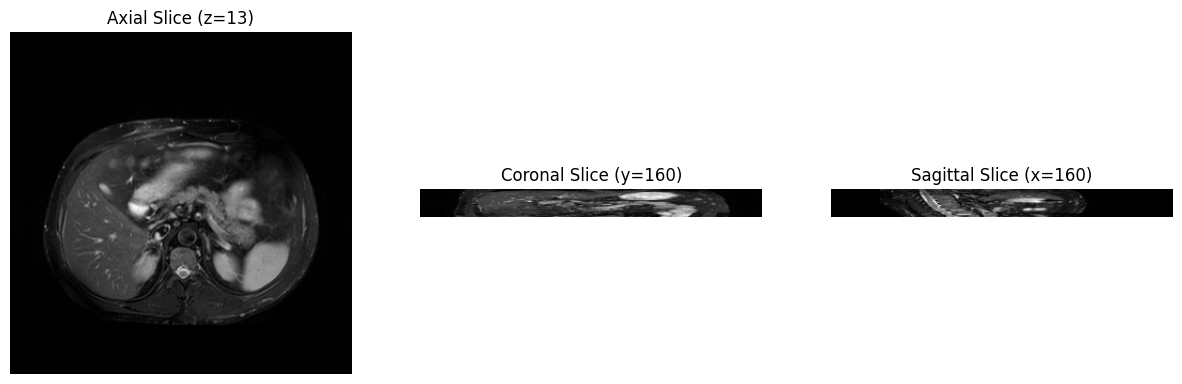

In [21]:
def display_nii_slices(nii_file, slice_indices=None):
    """
    Affiche des coupes axiale, coronale et sagittale d'un fichier NIfTI.
    
    :param nii_file: Chemin vers le fichier NIfTI (.nii ou .nii.gz)
    :param slice_indices: Tuple avec les indices des coupes (axiale, coronale, sagittale), 
                          si None, on prend les coupes du milieu.
    """
    # Charger le fichier NIfTI
    nii_data = nib.load(nii_file)
    img_data = nii_data.get_fdata()

    # Si les indices de coupes ne sont pas fournis, prendre les coupes du milieu
    if slice_indices is None:
        slice_indices = (img_data.shape[2] // 2,  # Axial (z)
                         img_data.shape[1] // 2,  # Coronal (y)
                         img_data.shape[0] // 2)  # Sagittal (x)
    
    # Extraire les coupes
    axial_slice = img_data[:, :, slice_indices[0]]  # Axe axial (z)
    coronal_slice = img_data[:, slice_indices[1], :]  # Axe coronal (y)
    sagittal_slice = img_data[slice_indices[2], :, :]  # Axe sagittal (x)

    # Afficher les coupes
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(axial_slice.T, cmap='gray', origin='lower')
    axes[0].set_title(f'Axial Slice (z={slice_indices[0]})')
    axes[0].axis('off')

    axes[1].imshow(coronal_slice.T, cmap='gray', origin='lower')
    axes[1].set_title(f'Coronal Slice (y={slice_indices[1]})')
    axes[1].axis('off')

    axes[2].imshow(sagittal_slice.T, cmap='gray', origin='lower')
    axes[2].set_title(f'Sagittal Slice (x={slice_indices[2]})')
    axes[2].axis('off')

    plt.show()

# Exemple d'utilisation :
nii_file_path = 'CHAOS-MRT2/02-T2SPIR-src.nii.gz'  # Chemin vers ton fichier .nii ou .nii.gz
display_nii_slices(nii_file_path)


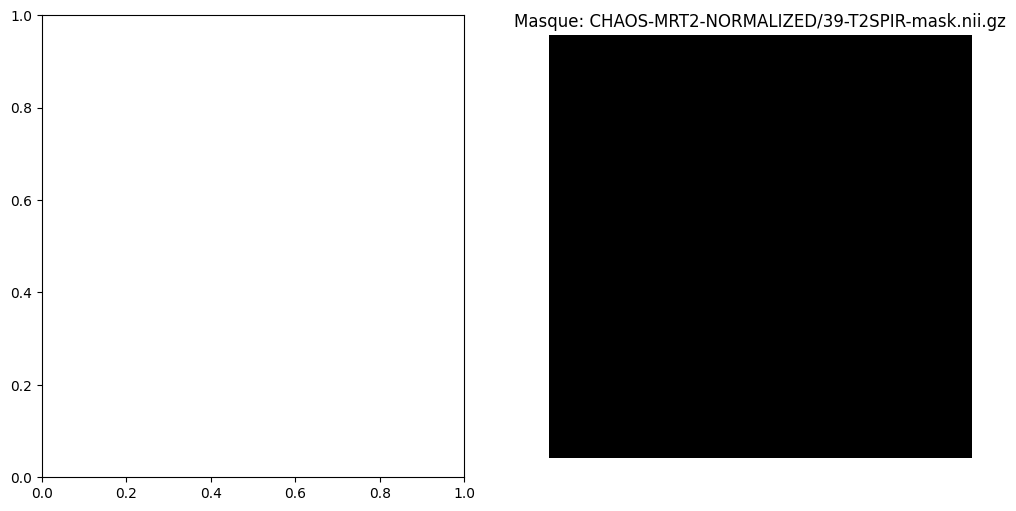

In [24]:
# Charger les images source et masque
mask_img = nib.load('predicted_mask.nii.gz').get_fdata()
    
    # Extraire une coupe 2D au milieu de l'axe z
slice_z_mask = mask_img[:, :, mask_img.shape[2] // 2]
    
    # Créer une figure pour afficher les deux images côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Afficher l'image source

axes[1].imshow(slice_z_mask.T, cmap='gray', origin='lower')
axes[1].set_title(f'Masque: {mask_file}')
axes[1].axis('off')
plt.show()

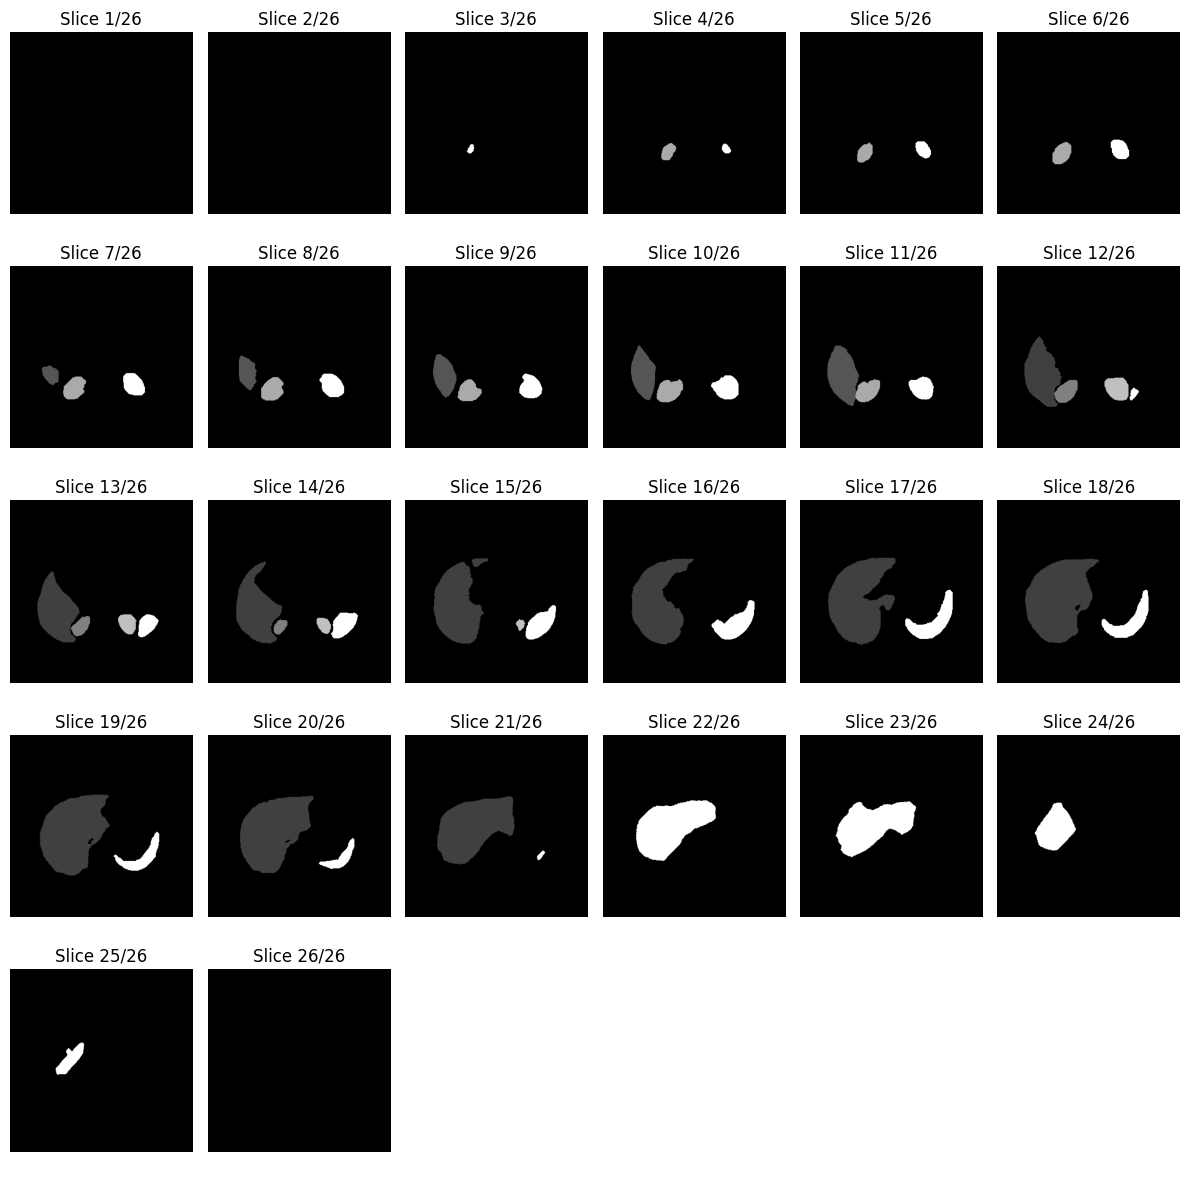

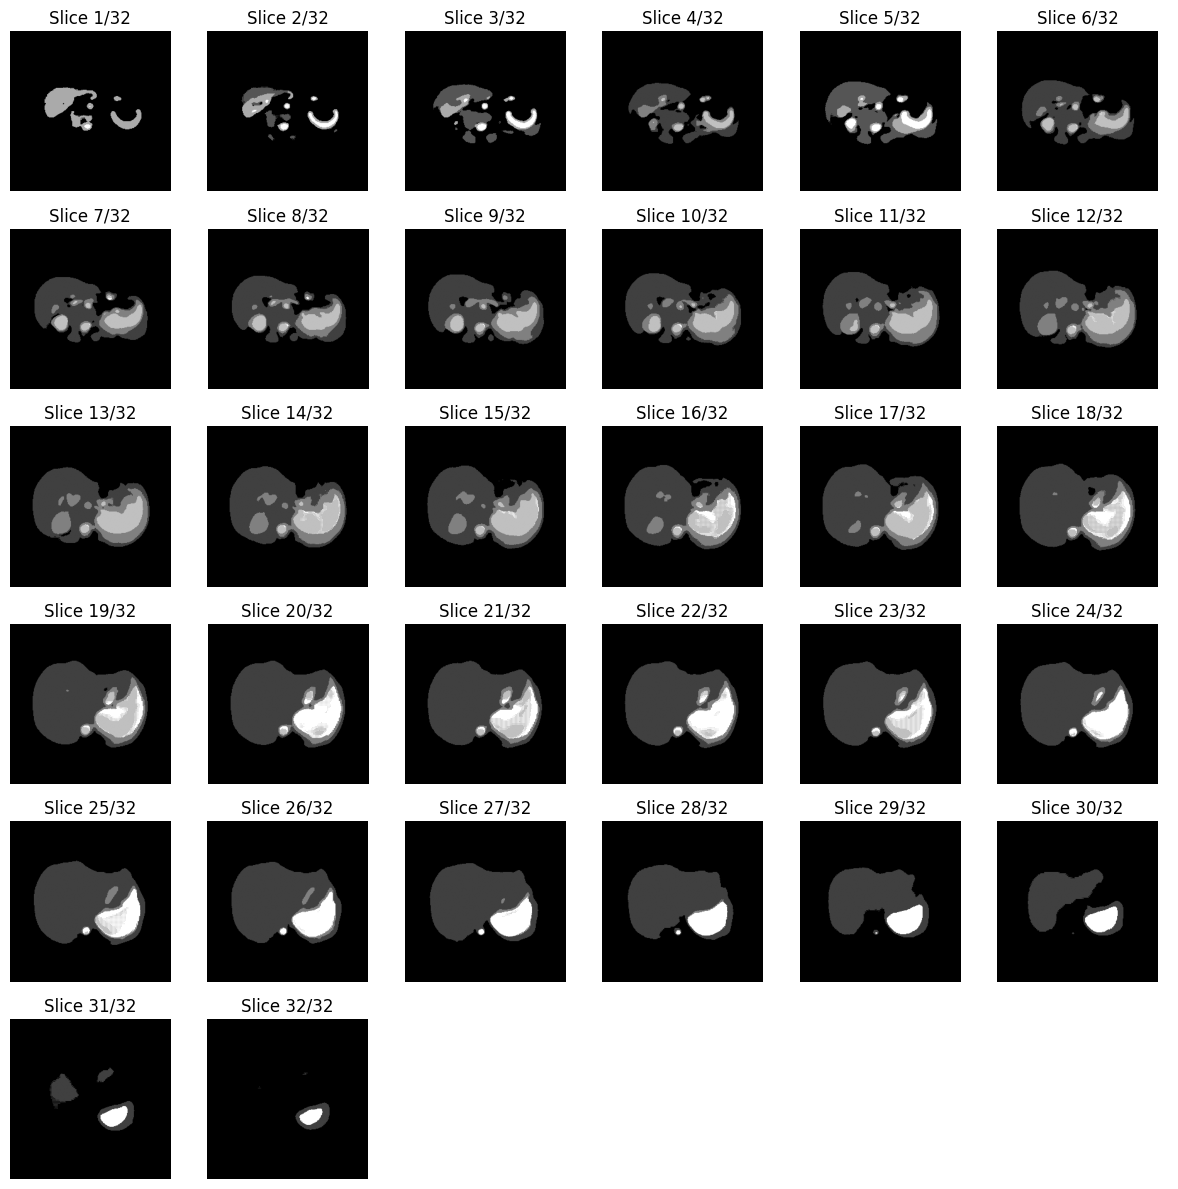

In [11]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

def display_all_slices(nii_file, axis=2, max_slices=16):
    """
    Affiche les slices d'un fichier NIfTI dans une grille de sous-plots.
    
    :param nii_file: Chemin vers le fichier NIfTI (.nii ou .nii.gz)
    :param axis: Axe selon lequel afficher les coupes (0: Sagittal, 1: Coronal, 2: Axial)
    :param max_slices: Nombre maximum de slices à afficher
    """
    # Charger le fichier NIfTI
    nii_data = nib.load(nii_file)
    img_data = nii_data.get_fdata()

    # Nombre de coupes dans l'axe spécifié
    num_slices = img_data.shape[axis]

    # Limiter le nombre de slices à afficher
    num_slices_to_display = min(num_slices, max_slices)

    # Calculer la disposition de la grille
    cols = int(np.ceil(np.sqrt(num_slices_to_display)))
    rows = int(np.ceil(num_slices_to_display / cols))

    # Créer la figure pour les sous-plots
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    
    # Si le nombre de sous-plots est inférieur aux cases dans la grille
    axes = axes.flatten()

    # Afficher chaque slice dans un sous-plot
    for i in range(num_slices_to_display):
        if axis == 0:  # Sagittal
            slice_img = img_data[i, :, :]
        elif axis == 1:  # Coronal
            slice_img = img_data[:, i, :]
        elif axis == 2:  # Axial
            slice_img = img_data[:, :, i]

        axes[i].imshow(np.rot90(slice_img), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Slice {i+1}/{num_slices}')

    # Cacher les axes non utilisés si la grille est plus grande que le nombre de slices
    for ax in axes[num_slices_to_display:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Exemple d'utilisation

display_all_slices("CHAOS-MRT2-NORMALIZED/02-T2SPIR-mask.nii.gz", axis=2, max_slices=32)
display_all_slices('predicted_mask_train0test19.0.nii.gz', axis=2, max_slices=32)



Text(0, 0.5, 'loss value')

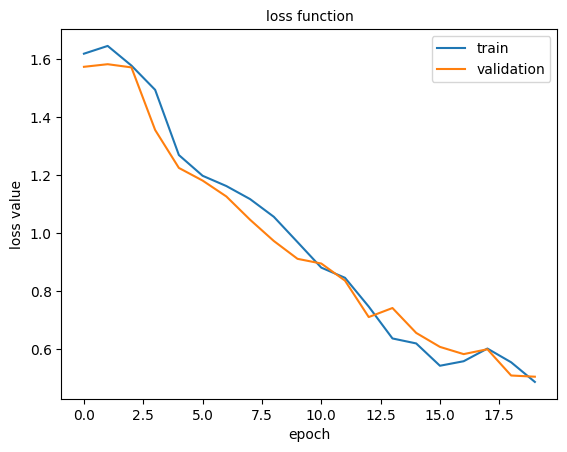

In [10]:
plt.plot(range(n_epochs), train_losses)
plt.plot(range(n_epochs), valid_losses)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)


In [22]:


nii_file = 'predicted_mask_train0.nii.gz' # ou .nii si vous avez des fichiers non compressés
nii_img = nib.load(nii_file)

# Extraire les données sous forme de tableau NumPy
mask_array = nii_img.get_fdata()

# Vérifier le type des données
print(mask_array.dtype)

# Vérifier les valeurs uniques dans le masque
print(np.unique(mask_array))
# a faire l'évaluation


float64
[0.]


In [16]:
def get_all_prediction(model):
    preds = torch.tensor([], dtype=torch.long)
    targets = torch.tensor([], dtype=torch.long)
    for data, label in zip(x_test,y_test):
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        with torch.no_grad():
            output = model(data)
        targets = torch.cat((targets, label.cpu()), dim = 0)
        preds = torch.cat((preds, torch.max(output.cpu(), 1)[1]), dim = 0)
    return targets.numpy(), preds.numpy()

In [17]:
targets, preds = get_all_prediction(UNet3D)  # comprendre comment fabriquer les loaders

RuntimeError: Boolean value of Tensor with more than one value is ambiguous